# Bayesian additive regression tree

<a href="http://www-stat.wharton.upenn.edu/~edgeorge/Research_papers/BART%20June%2008.pdf">paper</a>

a sum-of-trees model for approximating an unknown function

To avoid overfitting, BART uses a regularization prior that forces each tree to be able to explain only a limited subset of the relationships between the covariates and the predictor variable.

### BART:a sum-of-trees model + a regularization prior on the parameters of that model

sum-of-trees model

$y=f(x)+ \epsilon$..$f(x)$->$E(y|x)=h(x)=\sum_{j}^{m}g_{j}(x)$, $g(x)$ us a regression tree
for a regression tree, the value $\mu_{j}$ of the terminal mode is assigned to a sample with $X={x_{1},x_{2},....x_{p}}$, so we can have $g(x;T,M)$ with T is the nodes and decision rules, M is the $\mu$, and 
$y=\sum_{j}^{m}g(x;T_{j},M_{j})+\epsilon$, different trees have different $T_{j},M_{j}$

When every terminal node assignment depends on just a single component of  x, the sum-of-trees model reduces to a simple additive function, a sum of step functions of the individual components of x. m is the number of parameters, with how many trees, So how to set the m

#### the choice of m
a fast and robust option is to choose m=200,then maybe check if a couple of other values makes any difference, to look if the performance improve with the increased m

A regularization prior
Without such a regularizing influence, large tree components would overwhelm the rich structure,thereby limiting the advantages of the additive representation both in terms of function approximation and computation.
<img src="image/bart_prior.png" width="800" height="400">

#### prior for T
1.the depth of the tree
2.distribution splitting variables-- uniform
3.the distribution on the splitting rule assignment in each interior node

####  prior for $\mu|T$
using a Gaussian distribution N(0,$\sigma$),$\sigma=\frac{0.5}{k\sqrt(m)}$, with k and m control the individual tree effects, which should not be too large

#### prior for $\sigma$
the inverse chi-square distribution,For automatic use, Chipman et al. (2010) recommend the default setting 3,0.9 with $\nu,\lambda$


### Using backfitting MCMC algorithm to sampling

chanllenge is to sample from the posterior $(T_{j},M_{j}|T_{(j)},M_{(j)},\sigma)$ in Gibbs sampler

what is the relationship between $T_{j},M_{j}$ and $T_{(j)},M_{(j)}$,  $R_{j}=y-\sum_{k<>j}g(x;T_{k},M_{k})$

for $T_{j},M_{j}|R_{j},\sigma$, it can be sampled $M_{j}|T_{j},R_{j},\sigma, T_{j}|R_{j},\sigma$

in $T_{j}|R_{j},\sigma$ is without $M_{j}$, which can be integrated, as $R_{j}=g(x;T_{j},M_{j})$ based on $T_{j},M_{j}$

#### How to draw $T_{j}$, also a MH algorithm with always accepting

propose a new tree based on the current tree, like add a terminal node and change decision rules of the nodes

so, first,have a proposal $T_{j}^{*}$, and we have $M_{j}^{*} and have R_{j}^{*}, which is used to the next draw of $T_{j}$
each tree has its modification and end the gibbs,


the post samples can give approximation to the y and can be used to test partial dependance

and the frequency of component x to be used as the splitting rules can help do the variable selection

#### BART+ probit =>classification

$P(Y=1|x)=\Phi(G(x))$... without $\sigma, G(x)=\sum g(x;M,T)$

with $M^{*}and T^{*}$, we can get G(x) then use $Z_{i}$ n samples to get appromation to P(Y=1|x), so Z is N(G(x),1)

### BART code
use pymc3
use

In [3]:
%matplotlib inline
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import arviz as az
from scipy.special import expit

In [4]:
az.style.use('arviz-grayscale')
plt.rcParams["figure.dpi"] = 300
np.random.seed(5453)
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

In [14]:
data = pd.read_csv("bikes_hour.csv")
data = data[::50]
data.sort_values(by='hr', inplace=True)
data.hr.values.astype(float)
data


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
4850,4851,2011-07-26,3,0,7,0,0,2,1,1,0.70,0.6667,0.79,0.1045,8,20,28
5450,5451,2011-08-20,3,0,8,0,0,6,0,1,0.60,0.5455,0.88,0.0000,21,107,128
3650,3651,2011-06-06,2,0,6,0,0,1,1,1,0.62,0.5909,0.78,0.1343,11,18,29
6250,6251,2011-09-23,4,0,9,0,0,5,1,2,0.62,0.5455,0.94,0.0896,11,41,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13650,13651,2012-07-27,3,1,7,23,0,5,1,1,0.76,0.7273,0.66,0.0000,34,155,189
14250,14251,2012-08-21,3,1,8,23,0,2,1,1,0.62,0.5758,0.83,0.0000,23,113,136
14850,14851,2012-09-15,3,1,9,23,0,6,0,1,0.54,0.5152,0.60,0.0000,47,182,229
10700,10701,2012-03-26,2,1,3,23,0,1,1,1,0.34,0.2879,0.25,0.5224,2,46,48


In [15]:
X = np.atleast_2d(data["hr"]).T
Y = data["cnt"]

In [16]:
with pm.Model() as bart_g:
    σ= pm.HalfNormal('σ', Y.std())
    μ = pm.BART('μ', X, Y, m=50)
    y = pm.Normal('y', μ, σ, observed=Y)
    idata_bart_g = pm.sample(2000, chains=1, return_inferencedata=True)

C:\Users\maoru\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
The BART model is experimental. Use with caution.
Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


C:\Users\maoru\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\maoru\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: need at least one array to stack

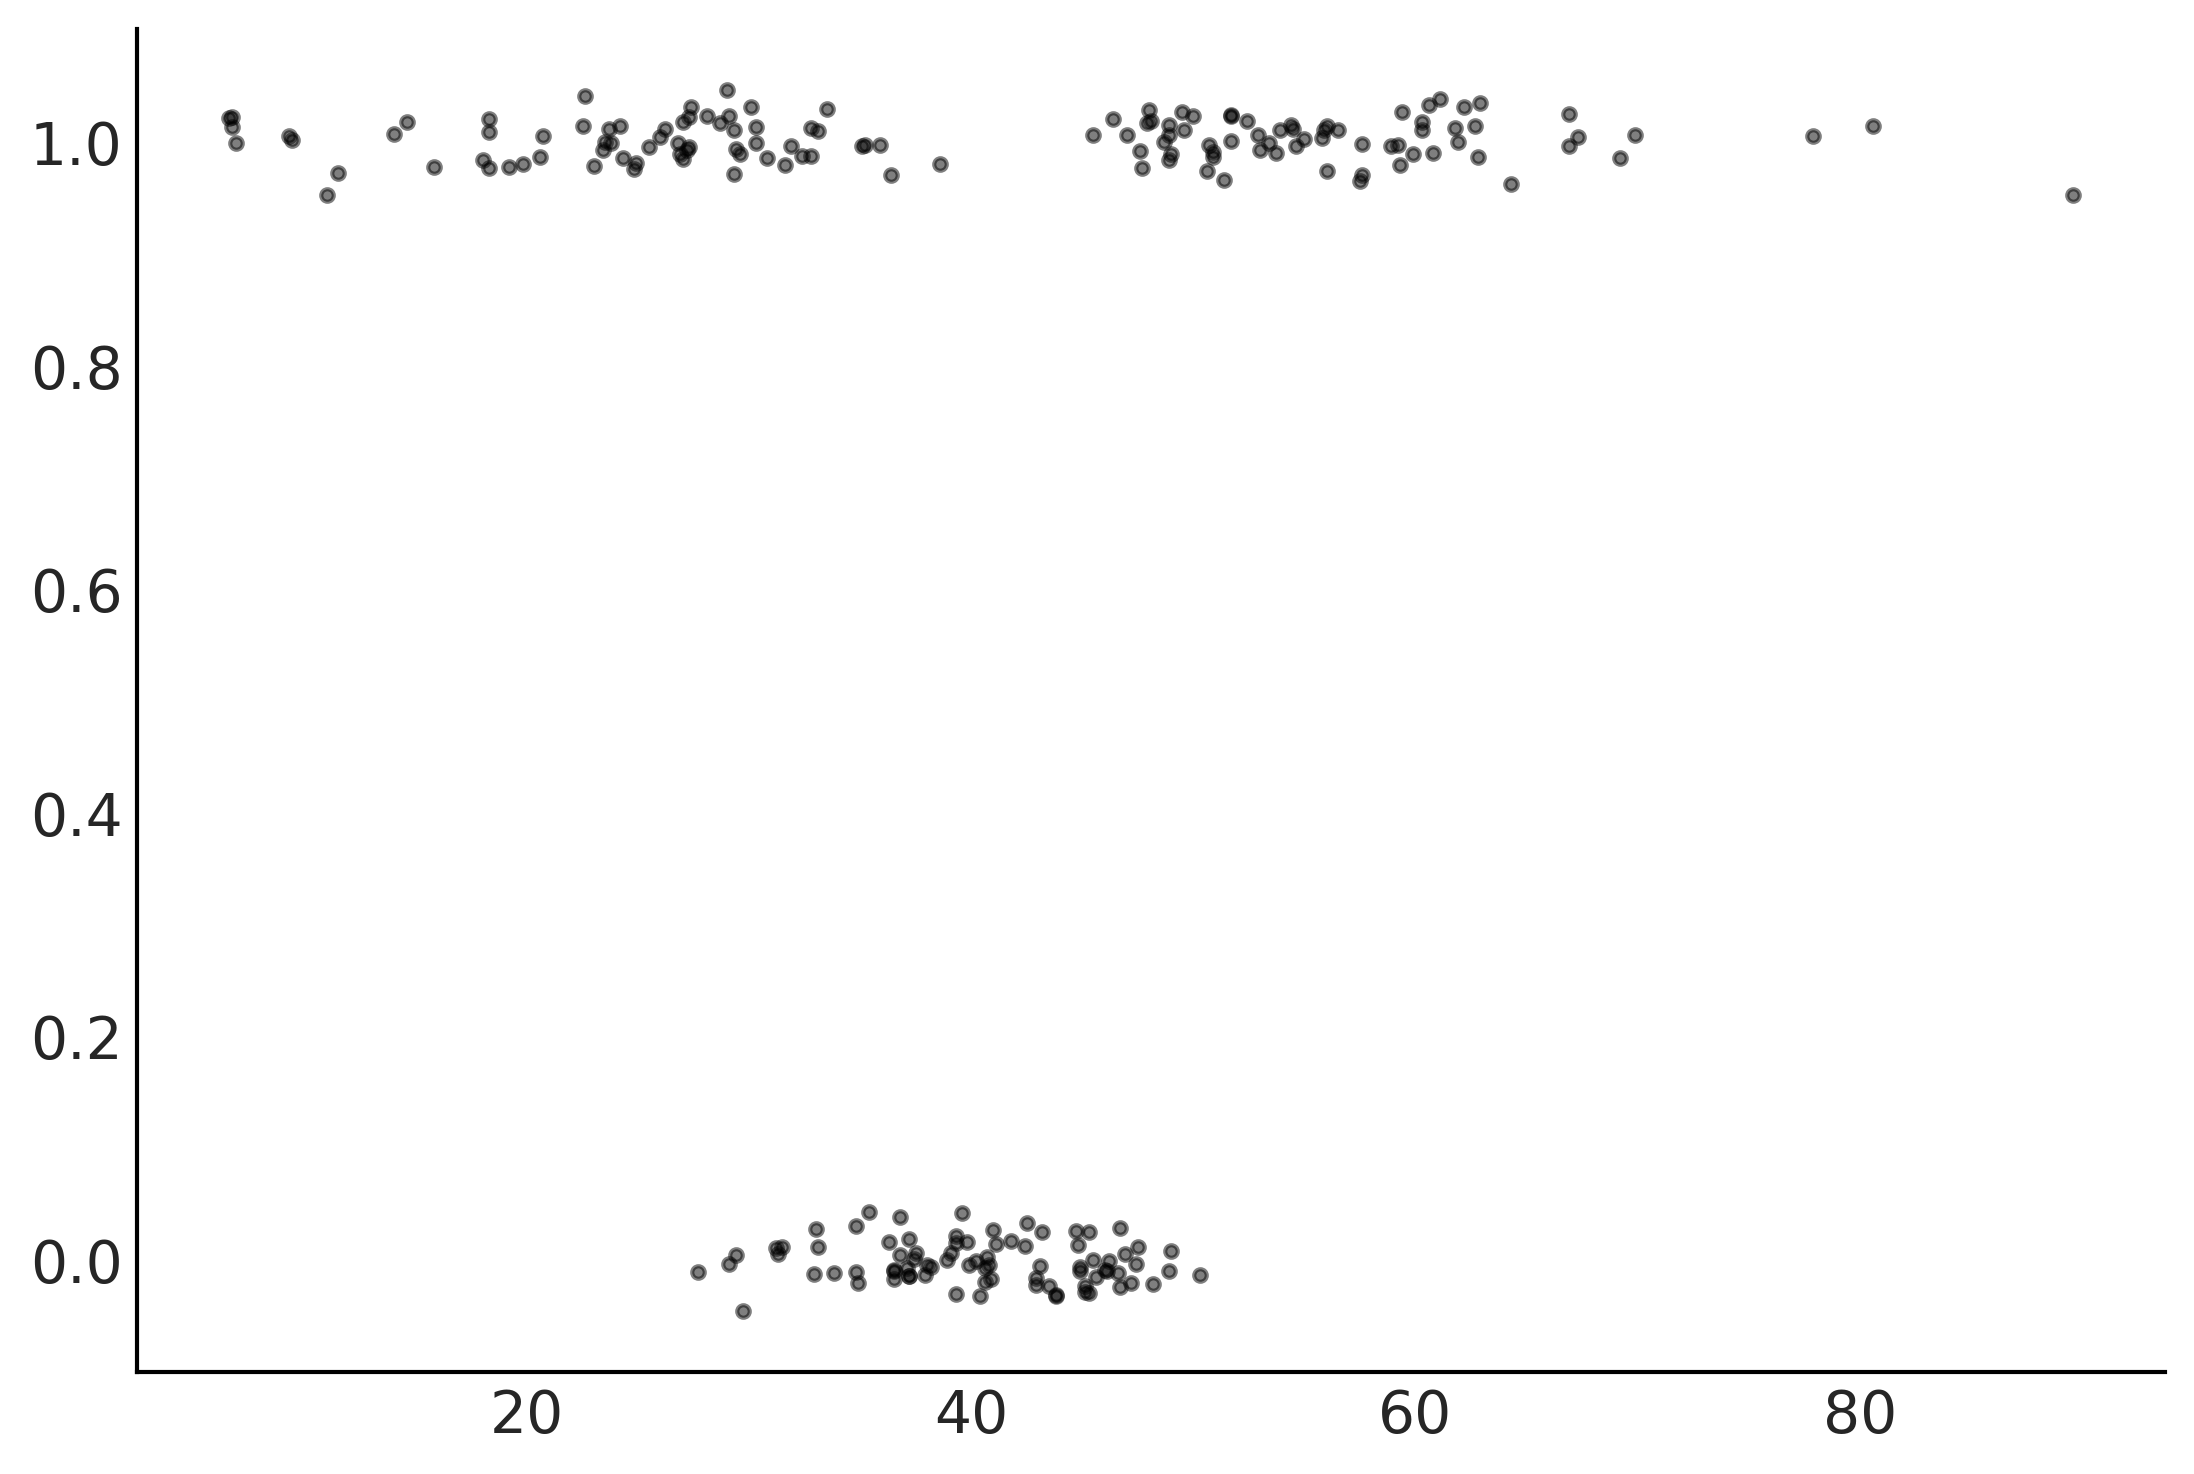

In [18]:
space_in = pd.read_csv("space_influenza.csv")
X = np.atleast_2d(space_in["age"]).T
Y = space_in["sick"]


Y_jittered = np.random.normal(Y, 0.02)
plt.plot(X[:,0], Y_jittered, ".", alpha=0.5)